# Integrando Word2Vec

"A principal fonte de valor do mundo não é mais o petróleo, mas os dados." Você provavelmente já ouviu essa frase, mas já se perguntou o que isso realmente significa? Com o Word2Vec, você descobrirá o poder das palavras em grandes conjuntos de dados, fornecendo ferramentas para enfrentar problemas do mundo real de maneira eficaz.

Nesse projeto vamos introduzir os modelos Skip-gram e CBOW, aprender, construir e aplicar para classificação de texto no PyTorch. Além disso, vamos incorporar embeddings pré-treinados do GloVe para melhorar os modelos. Uma seção opcional sobre aplicações avançadas de embeddings está disponível para exploração adicional

### Objetivos

- Compreender word embeddings com Word2Vec.
- Criar e treinar modelos básicos de Word2Vec utilizando as arquiteturas CBOW e Skip-gram.
- Obter modelos de embeddings grandes e pré-treinados e gerar word embeddings com eles.
- Treinar um modelo de Word2Vec em dados específicos de um domínio.

### Preparar setup - instalar bibliotecas

In [1]:
def warn(*args, **kwargs):
    pass
    
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

import importlib.util
import subprocess
import sys

def check_and_install(package, pip_name=None):
    if pip_name is None:
        pip_name = package
    spec = importlib.util.find_spec(package)
    if spec is None:
        print(f"{package} não está instalado. Instalando...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name])
    else:
        print(f"{package} já está instalado.")

In [3]:
check_and_install('gensim')
check_and_install('portalocker')
check_and_install('torchtext')
check_and_install('torch')
check_and_install('torchdata')

gensim já está instalado.
portalocker não está instalado. Instalando...
torchtext não está instalado. Instalando...
torch já está instalado.
torchdata não está instalado. Instalando...


### Importar bibliotecas

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

from IPython.core.display import display, SVG


from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import Dataset


import logging
from gensim.models import Word2Vec
from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import GloVe,vocab
from torchdata.datapipes.iter import IterableWrapper, Mapper
from torchtext.datasets import AG_NEWS
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from torchtext.data.utils import get_tokenizer
from torch.utils.data import DataLoader
from tqdm import tqdm

### Definir funções auxiliares

Definir uma função para plotar incorporações de palavras em um espaço 2D

In [43]:
def plot_embeddings(word_embeddings,vocab=vocab):

    tsne = TSNE(n_components=2, random_state=0)
    word_embeddings_2d = tsne.fit_transform(word_embeddings)

    # Plotting the results with labels from vocab
    plt.figure(figsize=(15, 15))
    for i, word in enumerate(vocab.get_itos() ):  # assuming vocab.itos gives the list of words in your vocab
        plt.scatter(word_embeddings_2d[i, 0], word_embeddings_2d[i, 1])
        plt.annotate(word, (word_embeddings_2d[i, 0], word_embeddings_2d[i, 1]))

    plt.xlabel("t-SNE component 1")
    plt.ylabel("t-SNE component 2")
    plt.title("Word Embeddings visualized with t-SNE")
    plt.show()

Define uma função que retorna palavras semelhantes a uma palavra específica calculando a distância do cosseno.

In [7]:
# This function returns the most similar words to a target 
#  word by calculating word vectors' cosine distance
def find_similar_words(word, word_embeddings, top_k=5):
    if word not in word_embeddings:
        print("Word not found in embeddings.")
        return []

    # Get the embedding for the given word
    target_embedding = word_embeddings[word]

    # Calculate cosine similarities between the target word and all other words
    similarities = {}
    for w, embedding in word_embeddings.items():
        if w != word:
            similarity = torch.dot(target_embedding, embedding) / (
                torch.norm(target_embedding) * torch.norm(embedding)
            )
            similarities[w] = similarity.item()

    # Sort the similarities in descending order
    sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

    # Return the top k similar words
    most_similar_words = [w for w, _ in sorted_similarities[:top_k]]
    return most_similar_words


Defina uma função que treina o modelo word2vec em dados de brinquedos.

In [8]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=1000):
    """
    Train the model for the specified number of epochs.
    
    Args:
        model: The PyTorch model to be trained.
        dataloader: DataLoader providing data for training.
        criterion: Loss function.
        optimizer: Optimizer for updating model's weights.
        num_epochs: Number of epochs to train the model for.

    Returns:
        model: The trained model.
        epoch_losses: List of average losses for each epoch.
    """
    
    # List to store running loss for each epoch
    epoch_losses = []

    for epoch in tqdm(range(num_epochs)):
        # Storing running loss values for the current epoch
        running_loss = 0.0

        # Using tqdm for a progress bar
        for idx, samples in enumerate(dataloader):

            optimizer.zero_grad()
            
            # Check for EmbeddingBag layer in the model
            if any(isinstance(module, nn.EmbeddingBag) for _, module in model.named_modules()):
                target, context, offsets = samples
                predicted = model(context, offsets)
            
            # Check for Embedding layer in the model
            elif any(isinstance(module, nn.Embedding) for _, module in model.named_modules()):
                target, context = samples
                predicted = model(context)
                
            loss = criterion(predicted, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()
            running_loss += loss.item()

        # Append average loss for the epoch
        epoch_losses.append(running_loss / len(dataloader))
    
    return model, epoch_losses

## Background

### Word2Vec
Word2Vec é uma família de métodos que transforma palavras em vetores numéricos, posicionando palavras semelhantes próximas umas das outras em um espaço definido por esses números. Dessa forma, é possível quantificar e analisar as relações entre palavras matematicamente. Por exemplo, palavras como "cat" e "kitten" ou "cat" e "dog" têm vetores próximos entre si, enquanto uma palavra como "book" está posicionada mais distante nesse espaço vetorial.
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0205EN-SkillsNetwork/Words.png" alt="Word2Vec example" class="bg-primary" width="400px">

 Vamos concentrar em dominar os modelos Skip-gram e Continuous Bag of Words (CBOW), que são precursores essenciais para entender os princípios da modelagem generativa e explorar o modelo **GloVe**

### GloVe
O GloVe (Global Vectors for Word Representation) é outro algoritmo popular para aprendizado de word embeddings. Diferentemente do Word2Vec, que se baseia na previsão de palavras de contexto ou alvo, o GloVe foca em capturar estatísticas globais de coocorrência de palavras de todo o corpus. Ele constrói uma matriz de coocorrência que representa com que frequência as palavras aparecem juntas no texto. Essa matriz é então fatorada para obter os word embeddings. Por exemplo, se "Man" e "King" coocorrem muitas vezes, seus vetores serão semelhantes.
#### Abordagem do GloVe:
O modelo GloVe segue uma abordagem fundamental, construindo uma grande matriz de coocorrência entre palavras e seus contextos. Cada entrada na matriz representa a frequência com que uma palavra aparece dentro de um determinado contexto. O processo segue os seguintes passos:

1. Criar uma matriz de coocorrência palavra-contexto:
O modelo começa gerando uma matriz que captura a informação de coocorrência entre palavras e seus contextos adjacentes. Cada elemento na matriz representa a frequência de coocorrência de pares palavra-contexto no conjunto de treinamento.

2. Aplicar fatoração da matriz:
Em seguida, o modelo aplica métodos de fatoração para aproximar a matriz de coocorrência palavra-contexto. O objetivo é decompor a matriz original em representações de menor dimensão que capturam as relações semânticas entre palavras e contextos.

3. Obter embeddings de palavras e contextos:
Através da fatoração da matriz de coocorrência, o modelo obtém embeddings para palavras e contextos. Esses embeddings são representações numéricas que codificam o significado semântico e as relações entre palavras e contextos.

#### Processo de treinamento:
- Inicialize as matrizes WF (Word-Feature matrix) e FC (Feature-Context matrix) com pesos aleatórios.
- Realize uma operação de multiplicação entre essas matrizes para obter WC', uma aproximação de WC (matriz de coocorrência original).
- Avalie a similaridade entre WC' e WC.
- Utilize Stochastic Gradient Descent (SGD) repetidamente para minimizar o erro entre WC' e WC.
- 
Após o treinamento, a matriz WF resultante fornece os word embeddings ou representações vetoriais para cada palavra (o vetor verde no diagrama). A dimensionalidade desses vetores pode ser definida ajustando o valor de F, permitindo uma representação compacta da semântica das palavras.

#### Vantagens do GloVe:
O GloVe consegue incorporar tanto as estatísticas globais quanto as informações de contexto local. Isso resulta em word embeddings que não apenas capturam as relações semânticas entre palavras, mas também preservam certas relações sintáticas.

### Criar e treinar modelos Word2Vec
Começar com implementação simples do word2vec para treiná-lo em um conjunto de dados de brinquedo:

In [10]:
toy_data = """I wish I was little bit taller
I wish I was a baller
She wore a small black dress to the party
The dog chased a big red ball in the park
He had a huge smile on his face when he won the race
The tiny kitten played with a fluffy toy mouse
The team celebrated their victory with a grand parade
She bought a small, delicate necklace for her sister
The mountain peak stood majestic and tall against the clear blue sky
The toddler took small, careful steps as she learned to walk
The house had a spacious backyard with a big swimming pool
He felt a sense of accomplishment after completing the challenging puzzle
The chef prepared a delicious, flavorful dish using fresh ingredients
The children played happily in the small, cozy room
The book had an enormous impact on readers around the world
The wind blew gently, rustling the leaves of the tall trees
She painted a beautiful, intricate design on the small canvas
The concert hall was filled with thousands of excited fans
The garden was adorned with colorful flowers of all sizes
I hope to achieve great success in my chosen career path
The skyscraper towered above the city, casting a long shadow
He gazed in awe at the breathtaking view from the mountaintop
The artist created a stunning masterpiece with bold brushstrokes
The baby took her first steps, a small milestone that brought joy to her parents
The team put in a tremendous amount of effort to win the championship
The sun set behind the horizon, painting the sky in vibrant colors
The professor gave a fascinating lecture on the history of ancient civilizations
The house was filled with laughter and the sound of children playing
She received a warm, enthusiastic welcome from the audience
The marathon runner had incredible endurance and determination
The child's eyes sparkled with excitement upon opening the gift
The ship sailed across the vast ocean, guided by the stars
The company achieved remarkable growth in a short period of time
The team worked together harmoniously to complete the project
The puppy wagged its tail, expressing its happiness and affection
She wore a stunning gown that made her feel like a princess
The building had a grand entrance with towering columns
The concert was a roaring success, with the crowd cheering and clapping
The baby took a tiny bite of the sweet, juicy fruit
The athlete broke a new record, achieving a significant milestone in her career
The sculpture was a masterpiece of intricate details and craftsmanship
The forest was filled with towering trees, creating a sense of serenity
The children built a small sandcastle on the beach, their imaginations running wild
The mountain range stretched as far as the eye could see, majestic and awe-inspiring
The artist's brush glided smoothly across the canvas, creating a beautiful painting
She received a small token of appreciation for her hard work and dedication
The orchestra played a magnificent symphony that moved the audience to tears
The flower bloomed in vibrant colors, attracting butterflies and bees
The team celebrated their victory with a big, extravagant party
The child's laughter echoed through the small room, filling it with joy
The sunflower stood tall, reaching for the sky with its bright yellow petals
The city skyline was dominated by tall buildings and skyscrapers
The cake was adorned with a beautiful, elaborate design for the special occasion
The storm brought heavy rain and strong winds, causing widespread damage
The small boat sailed peacefully on the calm, glassy lake
The artist used bold strokes of color to create a striking and vivid painting
The couple shared a passionate kiss under the starry night sky
The mountain climber reached the summit after a long and arduous journey
The child's eyes widened in amazement as the magician performed his tricks
The garden was filled with the sweet fragrance of blooming flowers
The basketball player made a big jump and scored a spectacular slam dunk
The cat pounced on a small mouse, displaying its hunting instincts
The mansion had a grand entrance with a sweeping staircase and chandeliers
The raindrops fell gently, creating a rhythmic patter on the roof
The baby took a big step forward, encouraged by her parents' applause
The actor delivered a powerful and emotional performance on stage
The butterfly fluttered its delicate wings, mesmerizing those who watched
The company launched a small-scale advertising campaign to test the market
The building was constructed with strong, sturdy materials to withstand earthquakes
The singer's voice was powerful and resonated throughout the concert hall
The child built a massive sandcastle with towers, moats, and bridges
The garden was teeming with a variety of small insects and buzzing bees
The athlete's muscles were well-developed and strong from years of training
The sun cast long shadows as it set behind the mountains
The couple exchanged heartfelt vows in a beautiful, intimate ceremony
The dog wagged its tail vigorously, a sign of excitement and happiness
The baby let out a tiny giggle, bringing joy to everyone around"""

Preparar os dados tokenizando e criando um vocabulário a partir dos dados

In [12]:
# Step 1: Get tokenizer
tokenizer = get_tokenizer('basic_english')

In [13]:
# Step 2: Tokenize sentences
def tokenize_data(sentences):
    for sentence in sentences:
        yield tokenizer(sentence)

tokenized_toy_data = tokenizer(toy_data)

In [14]:
vocab = build_vocab_from_iterator(tokenize_data(tokenized_toy_data),
                                  specials = ['<unk>'])
vocab.set_default_index(vocab['<unk>'])

Verificar como fica uma frase após a tokenização

In [15]:
# Test
sample_sentence = "I wish I was a baller"
tokenized_sample = tokenizer(sample_sentence)
encoded_sample = [vocab[token] for token in tokenized_sample]
print("Encoded sample:", encoded_sample)

Encoded sample: [20, 108, 20, 7, 2, 133]


In [16]:
# a fuction to apply numericalization on all tokens
text_pipeline = lambda tokens: [vocab[token] for token in tokens]

In [17]:
text_pipeline

<function __main__.<lambda>(tokens)>

#### Aprofundar em duas arquiteturas principais para treinar embeddings word2vec:

Saco Contínuo de Palavras - Continuous Bag of Words(CBOW)
Para o modelo Continuous Bag of Words (CBOW), use um "contexto" para prever uma palavra-alvo. O "contexto" é tipicamente um conjunto de palavras circundantes. Por exemplo, se sua janela de contexto for de tamanho 2, então você pega duas palavras antes e duas palavras depois da palavra-alvo como contexto. A palavra-alvo está em vermelho e o contexto está em azul:

<table border="1">
    <tr>
        <th>Time Step</th>
        <th>Phrase</th>
    </tr>
    <tr>
        <td>1</td>
        <td><span style="color:blue;">I wish</span> <span style="color:red;">I</span> <span style="color:blue;">was  little </span></td>
    </tr>
    <tr>
        <td>2</td>
        <td><span style="color:blue;">wish I</span> <span style="color:red;">was</span> <span style="color:blue;">little bit </span></td>
    </tr>
    <tr>
        <td>3</td>
        <td><span style="color:blue;">I was</span> <span style="color:red;">little</span> <span style="color:blue;">  bit taller</span></td>
    </tr>
    <tr>
        <td>4</td>
        <td><span style="color:blue;">was little</span> <span style="color:red;">bit</span> <span style="color:blue;"> taller I</span></td>
    </tr>
    <tr>
        <td>5</td>
        <td><span style="color:blue;">little bit</span> <span style="color:red;">taller</span> <span style="color:blue;"> I wish</span></td>
    </tr>
    <tr>
        <td>6</td>
        <td><span style="color:blue;">bit taller</span> <span style="color:red;">I</span> <span style="color:blue;">wish I</span></td>
    </tr>
    <tr>
        <td>7</td>
        <td><span style="color:blue;">taller I</span> <span style="color:red;">wish</span> <span style="color:blue;">I was</span></td>
    </tr>
    <tr>
        <td>8</td>
        <td><span style="color:blue;">I wish</span> <span style="color:red;">I</span> <span style="color:blue;">was a</span></td>
    </tr>
    <tr>
        <td>9</td>
        <td><span style="color:blue;">wish I</span> <span style="color:red;">was</span> <span style="color:blue;">a baller</span></td>
    </tr>
</table>

In [19]:
# slide over the sequence and create training data:
CONTEXT_SIZE = 2

cobow_data = []
for i in range(1, len(tokenized_toy_data) - CONTEXT_SIZE):
    context = (
        [tokenized_toy_data[i - j -1] for j in range(CONTEXT_SIZE)]
        + [tokenized_toy_data[i + j + 1] for j in range(CONTEXT_SIZE)]
    )
    target = tokenized_toy_data[i]
    cobow_data.append((context, target))

In [21]:
# Exemple
print(cobow_data[1])

(['wish', 'i', 'was', 'little'], 'i')


<table border="1">
    <tr>
        <th>Time Step</th>
        <th>Phrase</th>
    </tr>
    <tr>
        <td>1</td>
        <td><span style="color:blue;">I wish</span> <span style="color:red;">I</span> <span style="color:blue;">was  little </span></td>
    </tr>
</table>

In [22]:
# Exemple
print(cobow_data[2])

(['i', 'wish', 'little', 'bit'], 'was')


<table border="1">
    <tr>
        <th>Time Step</th>
        <th>Phrase</th>
    </tr>
    <tr>
        <td>2</td>
        <td><span style="color:blue;">wish I</span> <span style="color:red;">was</span> <span style="color:blue;"> little bit</span></td>
    </tr>
</table>

$P(w_t| w_{t-2},w_{t-1},w_{t+1},w_{t+2})$ é a probabilidade de $w_t$, a palavra-alvo, condicionada à ocorrência de palavras contextuais $w_{t-2},w_{t-1},w_{t+1},w_{t+2}$.

<table border="1">
    <thead>
        <tr>
            <th>\( P(w_t| w_{t-2},w_{t-1},w_{t+1},w_{t+2}) \)</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>\( P(w_1 | w_{-1},w_0,w_2,w_3) = P(I | \text{I wish, was little}) \)</td>
        </tr>
        <tr>
            <td>\( P(w_2 | w_0,w_1,w_3,w_4) = P(was | \text{wish I, little bit}) \)</td>
        </tr>
        <tr>
            <td>\( P(w_3 | w_1,w_2,w_4,w_5) = P(little | \text{I was, bit taller}) \)</td>
        </tr>
        <tr>
            <td>\( P(w_4 | w_2,w_3,w_5,w_6) = P(bit | \text{was little, taller I}) \)</td>
        </tr>
        <tr>
            <td>\( P(w_5 | w_3,w_4,w_6,w_7) = P(taller | \text{little bit, I wish}) \)</td>
        </tr>
        <tr>
            <td>\( P(w_6 | w_4,w_5,w_7,w_8) = P(I | \text{bit taller, wish I}) \)</td>
        </tr>
        <tr>
            <td>\( P(w_7 | w_5,w_6,w_8,w_9) = P(wish | \text{taller I, I was}) \)</td>
        </tr>
    </tbody>
</table>


A função collate_batch processa lotes de dados, convertendo dados de contexto e texto de destino em formato numérico usando um vocabulário e organizando-os para treinamento do modelo.

In [24]:
def collate_batch(batch):
    target_list, context_list, offsets = [], [], [0]

    for _context, _target in batch:
        target_list.append(vocab[_target])
        processed_context = torch.tensor(text_pipeline(_context), dtype=torch.int64)
        context_list.append(processed_context)
        offsets.append(processed_context.size(0))

    target_list = torch.tensor(target_list, dtype = torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim = 0)
    context_list = torch.cat(context_list)

    return target_list.to(device), context_list.to(device), offsets.to(device)

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Selecionando as primeiras 10 amostras da lista cobow_data e processando-as usando a função collate_batch. As saídas são as palavras-alvo tokenizadas (target_list), as palavras de contexto circundantes (context_list) e os respectivos deslocamentos para cada amostra (offsets).

In [27]:
# Create a DataLoader object

BATCH_SIZE = 64

dataloader_cbow = DataLoader(
    cobow_data, 
    batch_size = BATCH_SIZE,
    shuffle = True,
    collate_fn = collate_batch
)

In [28]:
print(dataloader_cbow)

O modelo CBOW mostrado aqui começa com uma camada EmbeddingBag, que pega uma lista de comprimento variável de índices de palavras de contexto e produz uma incorporação média de tamanho embed_dim. Essa incorporação é então passada por uma camada linear que reduz sua dimensão para embed_dim/2. Após aplicar uma ativação ReLU, a saída é processada por outra camada linear, transformando-a para corresponder ao tamanho do vocabulário, permitindo assim que o modelo preveja a probabilidade de qualquer palavra do vocabulário como a palavra-alvo. O fluxo geral passa dos índices de palavras contextuais para a previsão da palavra central na abordagem Continuous Bag of Words.

In [31]:
class CBOW(nn.Module):
    # Initialize the CBOW model
    def __init__(self, vocab_size, embed_dim, num_class):
        super(CBOW, self).__init__()

        # Define the embedding layer using nn.EmbeddingBag
        # It outputs the average of context words embeddings
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse = False)

        # Define the first linear layer with input size embed_dim and output size embed_dim/2
        self.linear1 = nn.Linear(embed_dim, embed_dim//2)

        # Define the fully connected layer with input size embed_dim/2 and output size vocab_size
        self.fc = nn.Linear(embed_dim//2, vocab_size)

        self.init_weights()

    # Initialize the weights of the model's parameters
    def init_weights(self):
        # Initialize the weights of the embedding layer
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)

        # Initialize the weights of the fully connected layer
        self.fc.weight.data.uniform_(-initrange, initrange)

        # Initialize the biases of the fully connected layer to zeros
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        # Pass the input text and offsets through the embeddings layer
        out = self.embedding(text, offsets)

        # Apply the ReLU activation function to the output of the first linear layer
        out = torch.relu(self.linear1(out))

        # Pass the output of the ReLU activation through the fully connected layer
        return self.fc(out)

In [32]:
# Create an instance of the CBOW model
vocab_size = len(vocab)
emsize = 24
model_cbow = CBOW(vocab_size, emsize, vocab_size).to(device)

In [33]:
# Define the loss function, optimizer, and scheduler for training
LR = 5

# Define the CrossEntropyLoss criterion. It is commonly used for multi-class classification tasks.
# This criterion combines the softmax function and the negative log-likelihood loss.
criterion = torch.nn.CrossEntropyLoss()

# Define the optimizer using stochastic gradient descent (SGD).
# It optimizes the parameters of the model_cbow, which are obtained by model_cbow.parameters().
# The learning rate (lr) determines the step size for parameter updates during optimization.
optimizer = torch.optim.SGD(model_cbow.parameters(), lr=LR)

# Define a learning rate scheduler.
# The StepLR scheduler adjusts the learning rate during training.
# It multiplies the learning rate by gamma every step_size epochs (here, 1.0).
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

In [35]:
# Train the model
model_cbow, epoch_losses = train_model(
    model_cbow,
    dataloader_cbow,
    criterion,
    optimizer,
    num_epochs=400
)

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:14<00:00, 28.15it/s]


Text(0.5, 0, 'epochs')

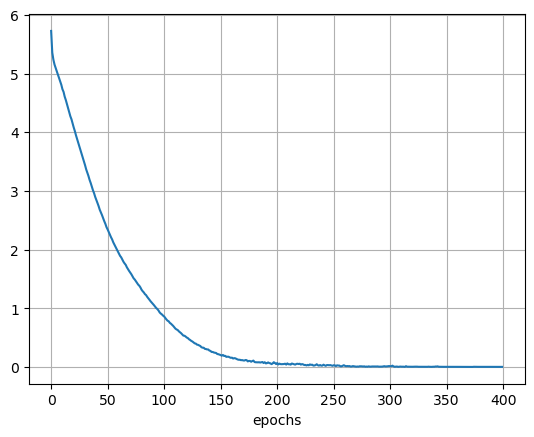

In [37]:
# Plot the loss values over the course of training
plt.plot(epoch_losses)
plt.grid()
plt.xlabel("epochs")

Os pesos do modelo são os embeddings de palavras reais. Podemos carregá-los em um array numpy

In [38]:
word_embeddings = model_cbow.embedding.weight.detach().cpu().numpy() 

In [39]:
word_embeddings

array([[ 0.45013314,  0.3659494 ,  0.16029108, ...,  0.2729677 ,
         0.08670604,  0.21327752],
       [ 0.5431949 ,  0.7077238 , -0.39285704, ..., -0.66566366,
         2.371285  , -0.07456522],
       [-2.0539064 ,  1.3276856 ,  0.75475264, ...,  0.5775611 ,
        -1.1789904 ,  0.987549  ],
       ...,
       [ 0.08908653,  1.4228565 ,  0.13075782, ..., -0.32276276,
        -0.34065953, -0.56383014],
       [-0.4328103 , -0.26424912,  0.51460177, ..., -0.59752357,
        -0.3394913 , -0.15401141],
       [-0.15730652,  0.00938564,  0.10423072, ..., -0.4021373 ,
         1.143997  ,  0.7094087 ]], dtype=float32)

Agora, vamos verificar o vetor incorporado para uma palavra de amostra. Observe o formato desse vetor que é igual ao emsize = 24 que você definiu anteriormente.

In [40]:
word = 'baller'
word_index = vocab.get_stoi()[word] # getting the index of the word in the vocab
print(word_embeddings[word_index])

[-0.2642564   0.20199542 -0.91929775 -0.6042451  -0.39162165  0.3181997
  0.55425113 -0.5940619   0.96197444 -0.15784168 -0.8771261   0.42693818
  0.4728431   0.47530234 -0.39690644  0.145907   -0.68569565 -1.0435553
 -1.1094979   0.49743134  0.640986    0.15501672 -0.62438947 -1.1296189 ]


Podemos verificar se os embeddings estão representando as similaridades entre as palavras. Para fazer isso, para fins de visualização, você precisa fazer redução de dimensão em embeddings de palavras para mapear o espaço de embedding para um espaço 2-d. Você pode fazer isso usando TSNE na função plot na seção de funções auxiliares.

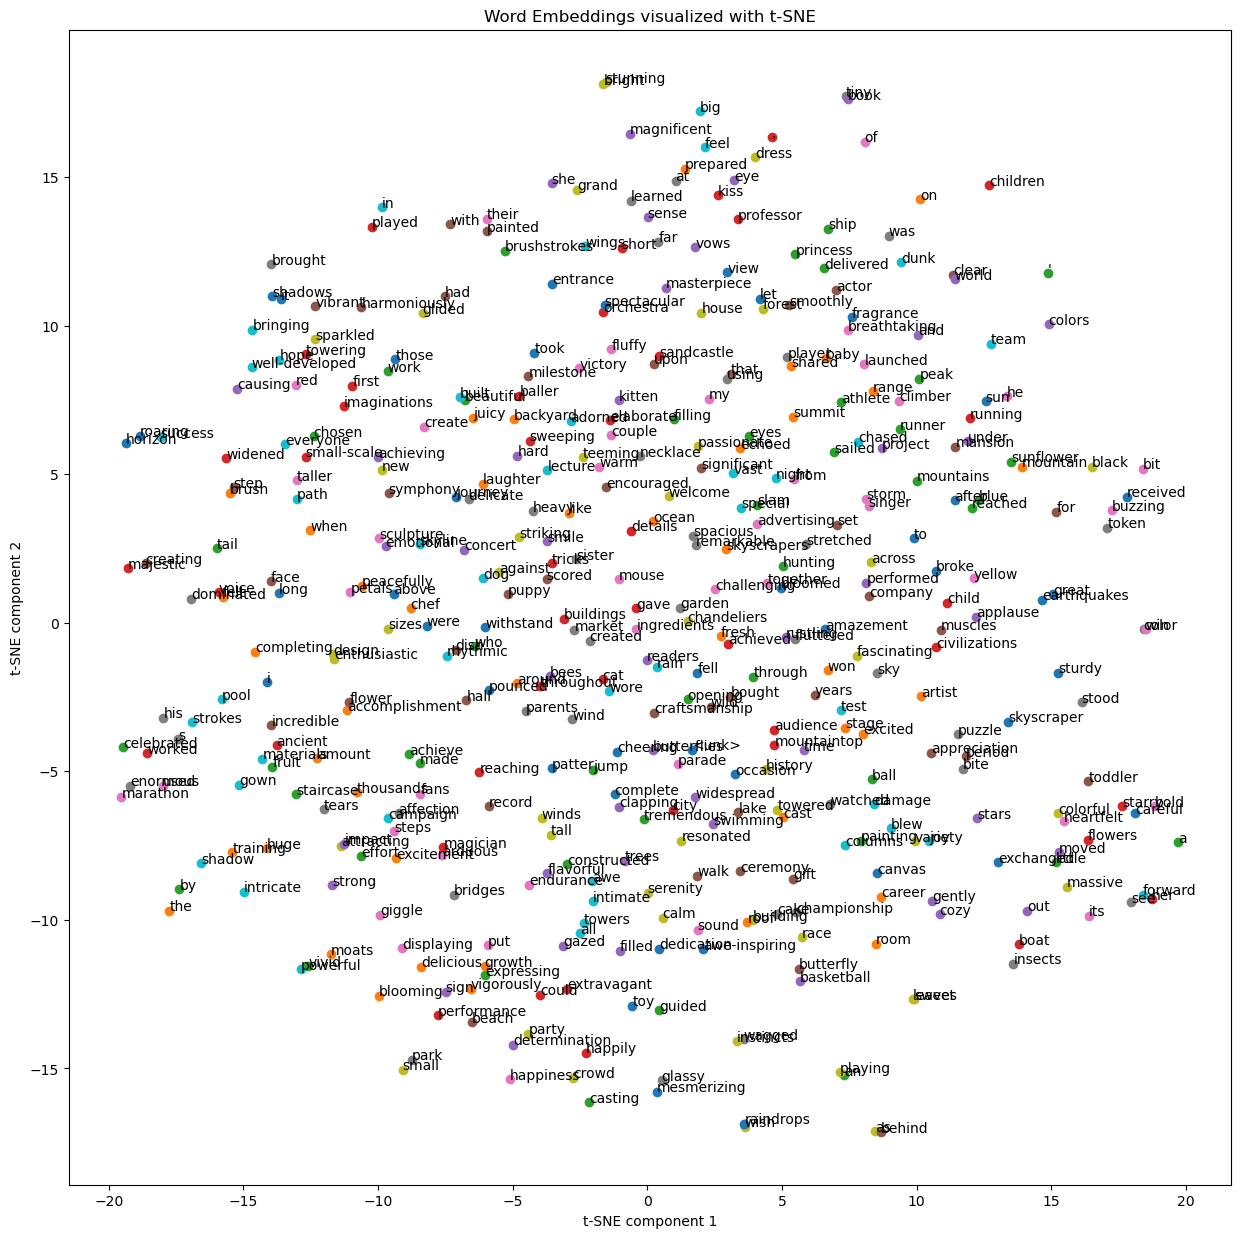

In [44]:
plot_embeddings(word_embeddings,vocab=vocab)

Ao examinar as projeções t-SNE, é evidente que mesmo com a inevitável perda de informação da redução de dimensionalidade e as limitações de um pequeno conjunto de dados, palavras com significados semelhantes se agrupam. Por exemplo, palavras como 'brilhante' e 'sombra' estão próximas perto do ponto (-15, -15) nos componentes 1 e 2. Da mesma forma, 'cachorro', 'gato' e 'rato' são agrupados em torno da coordenada (5, 5), e 'navegou' e 'vento' podem ser encontrados perto do ponto (5, -8)."

## Modelo Skip-gram

O modelo Skip-gram é uma das duas principais arquiteturas usadas no word2vec, uma técnica popular para aprender embeddings de palavras. No modelo Skip-gram, o objetivo é prever as palavras ao redor (contexto) dada uma palavra central (alvo). A ideia principal por trás deste modelo é que palavras que aparecem em contextos semelhantes tendem a ter significados semelhantes. Considere este exemplo:

**I was little bit taller,**

Assumindo um tamanho de janela de contexto de 2, as palavras em vermelho representam o contexto, enquanto a palavra destacada em azul significa o alvo:
**<span style="color:red;"> I was</span> <span style="color:blue;">little</span> <span style="color:red;">bit taller, </span>**

### Janela do Skip-gram:

Treinar o modelo Skip-gram usando o contexto real pode ser computacionalmente caro. Isso ocorre porque envolve prever probabilidades para cada palavra no vocabulário para cada posição no contexto, em oposição ao CBOW, que prevê as probabilidades para cada palavra no vocabulário apenas para a palavra-alvo. Para mitigar isso, várias técnicas de aproximação são empregadas.

Uma técnica de aproximação comum é dividir o contexto completo em partes menores e prevê-las uma de cada vez. Isso não apenas simplifica a tarefa de previsão, mas também ajuda em um melhor treinamento, pois fornece vários exemplos de treinamento de um único par contexto-alvo.

### Usando a primeira linha da tabela como exemplo:

Para o exemplo acima, a palavra-alvo é **"little"**. O contexto completo para esta palavra-alvo é:
**I was bit taller**

Na aproximação, em vez de usar o contexto completo para prever o alvo, você deve dividi-lo. Há quatro aproximações neste exemplo:
1. Aproximação 1: **I**
2. Aproximação 2: **was**
3. Aproximação 3: **bit**
4. Aproximação 4: **taller**

Para cada aproximação, o modelo Skip-gram visaria prever a palavra-alvo "little" usando apenas essa parte do contexto. Isso significa que, para a primeira aproximação, o modelo tentará prever "little" usando apenas a palavra "I". Para a segunda aproximação, ele tentará usar apenas a palavra "was" e assim por diante.

Concluindo, o modelo Skip-gram visa entender as relações entre palavras prevendo o contexto de uma determinada palavra-alvo. Técnicas de aproximação, como a ilustrada, ajudam a simplificar o processo de treinamento e torná-lo mais eficiente.

<table border="1">
    <tr>
        <th>Full Context with Target</th>
        <th>Target Word</th>
        <th>Original Target Context</th>
        <th>Approximation 1</th>
        <th>Approximation 2</th>
        <th>Approximation 3</th>
        <th>Approximation 4</th>
    </tr>
    <tr>
        <td><span style="color:red;"> I was</span> <span style="color:blue;">little</span> <span style="color:red;">bit taller, </span></td>
        <td>little</td>
        <td> I was bit taller,</td>
        <td>I</td>
        <td>was</td>
        <td>bit</td>
        <td>taller,</td>
    </tr>
    <tr>
        <td><span style="color:red;"> was little</span> <span style="color:blue;">bit</span> <span style="color:red;">taller, I </span></td>
        <td>bit</td>
        <td>was little taller, I</td>
        <td>was</td>
        <td>little</td>
        <td>taller,</td>
        <td>I</td>
    </tr>
    <tr>
        <td><span style="color:red;">little bit</span> <span style="color:blue;">taller,</span> <span style="color:red;">I wish </span></td>
        <td>taller,</td>
        <td>little bit I wish</td>
        <td>little</td>
        <td>bit</td>
        <td>I</td>
        <td>wish</td>
    </tr>
    <tr>
        <td><span style="color:red;"> bit taller,</span> <span style="color:blue;">I</span> <span style="color:red;">wish I </span></td>
        <td>I</td>
        <td>bit taller, wish I</td>
        <td>bit</td>
        <td>taller,</td>
        <td>wish</td>
        <td>I</td>
    </tr>
    <tr>
        <td><span style="color:red;"> taller, I</span> <span style="color:blue;">wish</span> <span style="color:red;">I was </span></td>
        <td>wish</td>
        <td>taller, I I was</td>
        <td>taller,</td>
        <td>I</td>
        <td>I</td>
        <td>was</td>
    </tr>
    <!-- More rows can be added in a similar pattern for other words in the phrase. -->
</table>


O objetivo é otimizar as probabilidades condicionais para obter embeddings. Otimize as probabilidades condicionais para obter embeddings de palavras de alta qualidade. A única diferença entre bag of words contínuos é a estrutura das probabilidades condicionais $P(w_{t+j}| w_{t})$ para o tamanho da sua janela $j=-2,-1,..,1,2.$

<table border="1">
    <tr>
        <th>j</th>
        <th>Target Word t=3 </th>
        <th>Context Word</th>
        <th>Probability</th>
    </tr>
    <tr>
         <th>-2</th>
        <td>little</td>
        <td>I</td>
        <td> P(I | little) </td>
    </tr>
    <tr>
          <th>-1</th>
        <td>little</td>
        <td>was</td>
        <td> P(was | little)</td>
    </tr>
    <tr>
         <th>1</th>
        <td>little</td>
        <td>bit</td>
        <td>P(bit | little)</td>
    </tr>
    <tr>
         <th>2</th>
        <td>little</td>
        <td>taller,</td>
        <td>P(taller | little) </td>
    </tr>
    <!-- Repeat rows for each context word for each target word -->
</table>




Em contraste com a notação padrão em probabilidade condicional, onde a variável dependente é normalmente representada como o alvo, a terminologia atual inverte essa convenção.

O código abaixo constrói um conjunto de dados skip-gram a partir de dados de brinquedo tokenizados, onde para cada palavra (alvo), ele reúne as palavras circundantes dentro de uma janela especificada (contexto) definida por CONTEXT_SIZE.

In [45]:
# Define the window size for the context around the target word.
CONTEXT_SIZE = 2

# Initialize an empty list to store the (target, context) pairs.
skip_data = []

# Iterate over each word in the tokenized toy_data, while excluding the first 
# and last few words determined by the CONTEXT_SIZE.
for i in range(CONTEXT_SIZE, len(tokenized_toy_data) - CONTEXT_SIZE):

    # For a word at position i, the context comprises of words from the preceding CONTEXT_SIZE
    # as well as from the succeeding CONTEXT_SIZE. The context words are collected in a list.
    context = (
        [tokenized_toy_data[i - j - 1] for j in range(CONTEXT_SIZE)]  # Preceding words
        + [tokenized_toy_data[i + j + 1] for j in range(CONTEXT_SIZE)]  # Succeeding words
    )

    # The word at the current position i is taken as the target.
    target = tokenized_toy_data[i]

    # Append the (target, context) pair to the skip_data list.
    skip_data.append((target, context))

In [46]:
# Window the skipgram
skip_data_=[[(sample[0],word) for word in  sample[1]] for sample in skip_data]

In [47]:
# Pairs of (target, context) words
skip_data_flat= [item  for items in  skip_data_ for item in items]
skip_data_flat[8:28]

[('little', 'was'),
 ('little', 'i'),
 ('little', 'bit'),
 ('little', 'taller'),
 ('bit', 'little'),
 ('bit', 'was'),
 ('bit', 'taller'),
 ('bit', 'i'),
 ('taller', 'bit'),
 ('taller', 'little'),
 ('taller', 'i'),
 ('taller', 'wish'),
 ('i', 'taller'),
 ('i', 'bit'),
 ('i', 'wish'),
 ('i', 'i'),
 ('wish', 'i'),
 ('wish', 'taller'),
 ('wish', 'i'),
 ('wish', 'was')]

In [48]:
# Creating a collate function to numericalize (target, context) pairs
def collate_fn(batch):
    target_list, context_list = [], []
    for _context, _target in batch:
        
        target_list.append(vocab[_target]) 
        context_list.append(vocab[_context])
        
    target_list = torch.tensor(target_list, dtype=torch.int64)
    context_list = torch.tensor(context_list, dtype=torch.int64)
    return target_list.to(device), context_list.to(device)

In [49]:
dataloader = DataLoader(
    skip_data_flat, 
    batch_size=BATCH_SIZE, 
    collate_fn=collate_fn
)

In [50]:
# Check a sample batch of target,context after collation
next(iter(dataloader))

(tensor([108,  20,   7, 272,  20, 108, 272, 136,   7,  20, 136, 376, 272,   7,
         376,  20, 136, 272,  20, 108, 376, 136, 108,  20,  20, 376,  20,   7,
         108,  20,   7,   2,  20, 108,   2, 133,   7,  20, 133,  14,   2,   7,
          14, 109, 133,   2, 109,   2,  14, 133,   2,   8, 109,  14,   8, 138,
           2, 109, 138, 198,   8,   2, 198,  10]),
 tensor([ 20,  20,  20,  20,   7,   7,   7,   7, 272, 272, 272, 272, 136, 136,
         136, 136, 376, 376, 376, 376,  20,  20,  20,  20, 108, 108, 108, 108,
          20,  20,  20,  20,   7,   7,   7,   7,   2,   2,   2,   2, 133, 133,
         133, 133,  14,  14,  14,  14, 109, 109, 109, 109,   2,   2,   2,   2,
           8,   8,   8,   8, 138, 138, 138, 138]))

Definir a rede Skip-gram. A camada embeddings é definida usando nn.Embedding, que cria embeddings de palavras para o tamanho de vocabulário e dimensão de embedding fornecidos. A camada fc é uma camada totalmente conectada com dimensão de entrada embed_dim e dimensão de saída vocab_size.

No método forward, o texto de entrada é passado pela camada embeddings para obter os embeddings de palavras. A saída da camada embeddings é então passada pela camada fc. A função de ativação ReLU é aplicada à saída da camada fc. A saída final é retornada.

In [51]:
class SkipGram_Model(nn.Module):

    def __init__(self, vocab_size, embed_dim):
        super(SkipGram_Model, self).__init__()
        # Define the embeddings layer
        self.embeddings = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim
        )
        
        # Define the fully connected layer
        self.fc = nn.Linear(in_features=embed_dim, out_features=vocab_size)

    def forward(self, text):
        # Perform the forward pass
        # Pass the input text through the embeddings layer
        out = self.embeddings(text)
        
        # Pass the output of the embeddings layer through the fully connected layer
        # Apply the ReLU activation function
        out = torch.relu(out)
        out = self.fc(out)
        
        return out

In [52]:
# Creating an instance of the model
emsize = 24
model_sg = SkipGram_Model(vocab_size, emsize).to(device)

In [53]:
# Train the model on toy data

LR = 5  # learning rate
#BATCH_SIZE = 64  # batch size for training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_sg.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

In [54]:
model_sg, epoch_losses=train_model(
    model_sg, 
    dataloader, 
    criterion, 
    optimizer, 
    num_epochs=400
)

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:27<00:00, 14.38it/s]


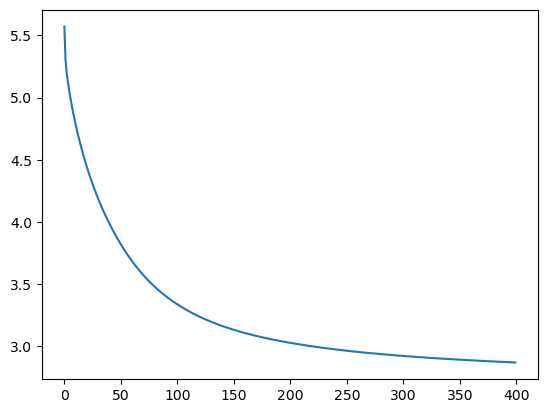

In [55]:
plt.plot(epoch_losses)

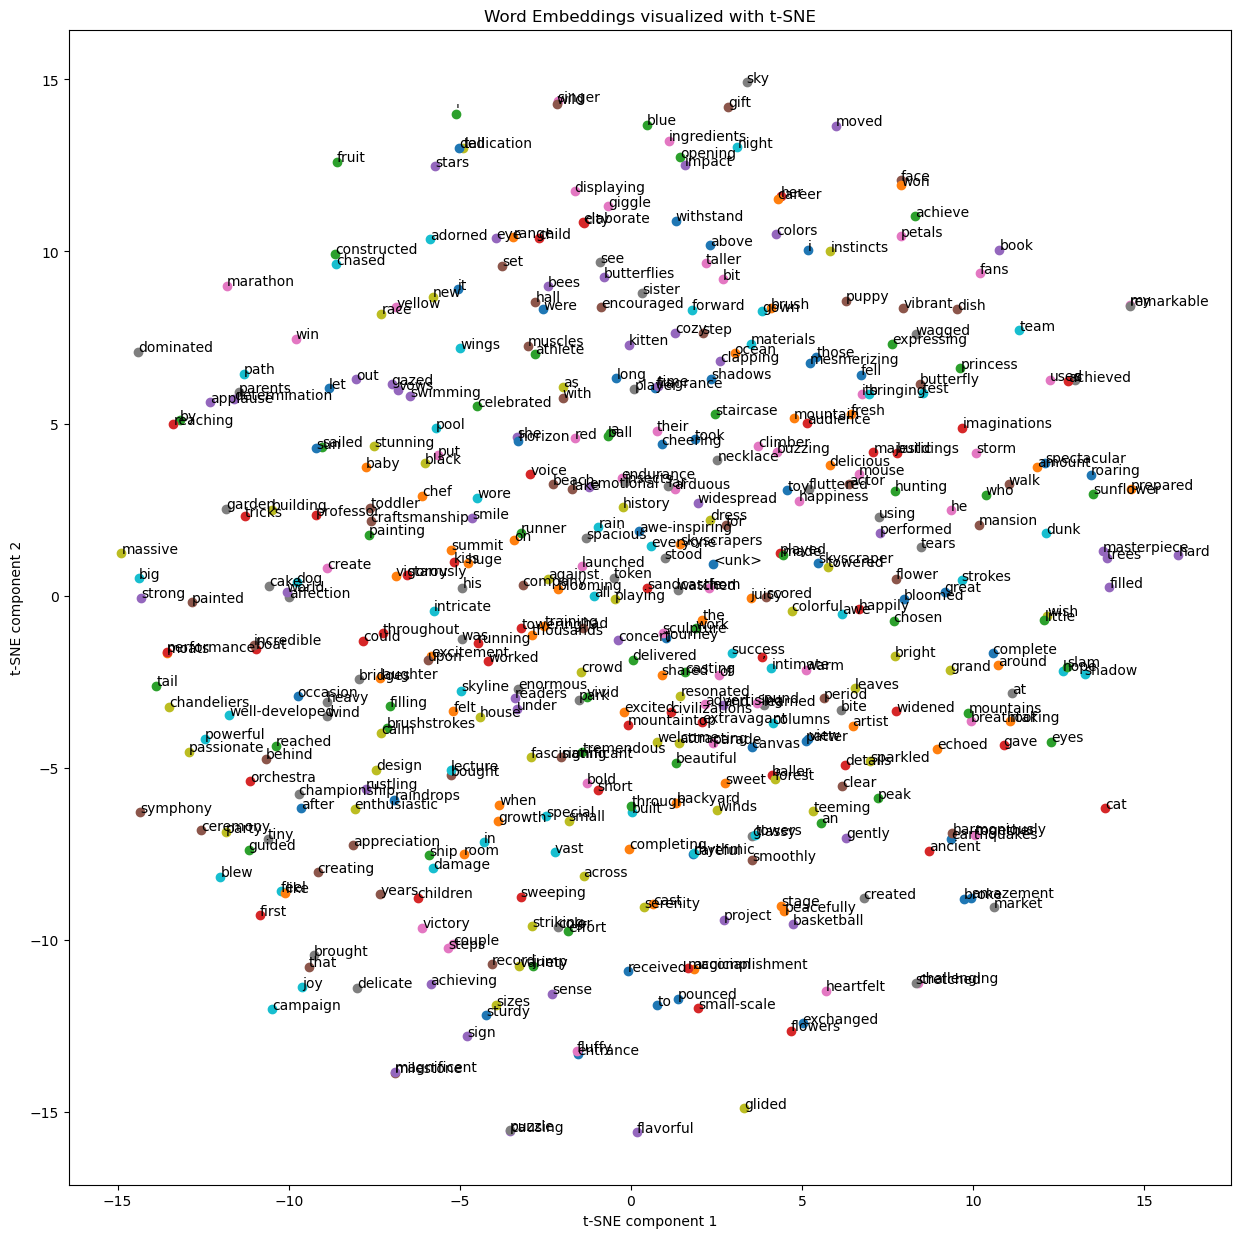

In [56]:
# plot the word embedding by reducing the dimensions using t-SNE
word_embeddings = model_sg.embeddings.weight.detach().cpu().numpy() 
plot_embeddings(word_embeddings,vocab=vocab)

Ao selecionar CBOW ou Skip-Gram, a melhor abordagem geralmente depende das especificidades da sua tarefa e dados. Se o seu conjunto de dados for pequeno, mas você precisar ter uma boa representação de palavras mais raras, Skip-gram pode ser a melhor escolha. Se a eficiência computacional for mais crítica e as palavras raras forem menos preocupantes, CBOW pode ser adequado. Também vale a pena notar que, para conjuntos de dados muito pequenos, os benefícios de embeddings de palavras neurais podem ser limitados, e métodos mais simples ou alavancagem de embeddings pré-treinados podem ser mais eficazes.

____
Esse material tem como referência o curso [Gen AI Foundational Models for NLP & Language Understanding](https://www.coursera.org/learn/gen-ai-foundational-models-for-nlp-and-language-understanding?specialization=generative-ai-engineering-with-llms)